# Topic Modeling / UN Genral Assembly Speeces

Original Data source: Jankin Mikhaylov, Slava; Baturo, Alexander; Dasandi, Niheer, 2017, "United Nations General Debate Corpus", https://doi.org/10.7910/DVN/0TJX8Y, Harvard Dataverse, V5
Further processing from "Blueprints for Text Analytics using Python"

In [1]:
import pandas as pd
from pandas_profiling import ProfileReport
import seaborn as sns
import matplotlib as plt
import re

In [2]:
# Tests to see if we are running in the Google Colaboratory environment
# If so, use an https URL to access the data.  Otherwise, load via the file path
try:
  import google.colab
  data_file_prefix = "https://raw.githubusercontent.com/slankas/DataScienceNotebooks/master/DataCleaning/"
  import plotly.io as pio
  pio.renderers.default = 'colab'
except:
  data_file_prefix = ""

In [3]:
pd.options.display.max_colwidth = 150

df = pd.read_csv(data_file_prefix+'un-general-debates-blueprint.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7507 entries, 0 to 7506
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   session       7507 non-null   int64 
 1   year          7507 non-null   int64 
 2   country       7507 non-null   object
 3   country_name  7507 non-null   object
 4   speaker       7480 non-null   object
 5   position      4502 non-null   object
 6   text          7507 non-null   object
dtypes: int64(2), object(5)
memory usage: 410.7+ KB


In [4]:
print(repr(df.iloc[0]["text"][0:200]))
print(repr(df.iloc[-1]["text"][0:200]))

'33: May I first convey to our President the congratulations of the Albanian delegation on his election to the Presidency of the twenty-fifth session of the General Assembly?\n34.\tIn taking up the work '
'Allow me at the outset to extend to Mr. Mogens Lykketoft my warm congratulations on his election to the high office of President of the General Assembly at its seventieth session. He assumes this offi'


In [5]:
df["text"]  =  df["text"].map(lambda text: re.sub(r"\d+:", "", text))
df["text"]  =  df["text"].map(lambda text: re.sub(r"\d+.", "", text))
df["text"]  =  df["text"].map(lambda text: re.sub(r"\t", " ", text))
print(repr(df.iloc[0]["text"][0:200]))

' May I first convey to our President the congratulations of the Albanian delegation on his election to the Presidency of the twenty-fifth session of the General Assembly?\n In taking up the work on the'


In [6]:
df["paragraphs"] = df["text"].map(lambda text: re.split('[.?!]\s*\n', text))
df["number_of_paragraphs"] = df["paragraphs"].map(len)
print(repr(df.iloc[0]["paragraphs"][0:3][0:200]))

[' May I first convey to our President the congratulations of the Albanian delegation on his election to the Presidency of the twenty-fifth session of the General Assembly', ' In taking up the work on the agenda of the twenty- fifth session of the General Assembly, which is being held on the eve of the twenty-fifth anniversary of the coming into force of the Charter of the United Nations, the peace-loving Member States would have wished to be in a position to present on this occasion some picture of positive and satisfactory activity on the part of the United Nations. The Albanian delegation, for its part, would have taken great pleasure in drawing up such a balance sheet of activities covering a quarter of a century, which is certainly no short period in the life of an international organization. Unfortunately, this is not the situation. Created on the day after victory had been achieved over the Powers of the Rome BerlinTokyo Axis and conceived in the spirit of the principles which p

<AxesSubplot:xlabel='year'>

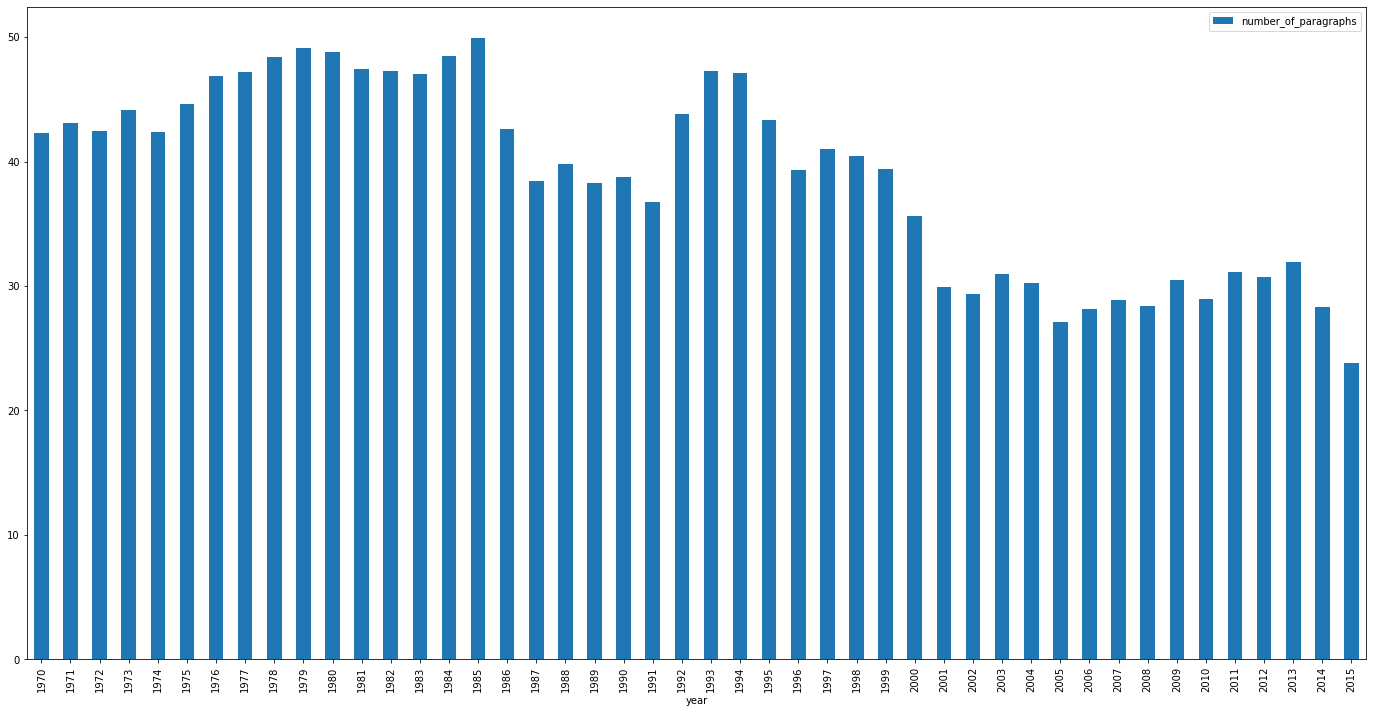

In [7]:
%matplotlib inline
df.groupby('year').agg({'number_of_paragraphs': 'mean'}).plot.bar(figsize=(24,12))

In [8]:

from sklearn.feature_extraction.text import TfidfVectorizer
from spacy.lang.en.stop_words import STOP_WORDS as stopwords

In [9]:
tfidf_text_vectorizer = TfidfVectorizer(stop_words=stopwords, min_df=5, max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(df['text'])
tfidf_text_vectors.shape

/home/jbslanka/mypython/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


(7507, 23615)

In [10]:
# flatten the paragraphs keeping the years
paragraph_df = pd.DataFrame([{ "text": paragraph, "year": year } 
                               for paragraphs, year in zip(df["paragraphs"], df["year"]) 
                                    for paragraph in paragraphs if paragraph])

In [11]:
tfidf_para_vectorizer = TfidfVectorizer(stop_words=stopwords, min_df=5, max_df=0.7)
tfidf_para_vectors = tfidf_para_vectorizer.fit_transform(paragraph_df["text"])
tfidf_para_vectors.shape

(280180, 24141)

## Nonnegative Matrix Factorization

### Full Speeches

In [12]:

from sklearn.decomposition import NMF

nmf_text_model = NMF(n_components=10, random_state=42)
W_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors)
H_text_matrix = nmf_text_model.components_

/home/jbslanka/mypython/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


In [13]:
def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

In [14]:
# Percentages that rapidly decrease indicate a well-pronouced topic. 
display_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names())


Topic 00
  co (0.83)
  operation (0.69)
  nuclear (0.40)
  disarmament (0.39)
  relations (0.27)

Topic 01
  terrorism (0.34)
  cooperation (0.31)
  reform (0.30)
  challenges (0.30)
  sustainable (0.27)

Topic 02
  africa (1.17)
  african (0.81)
  south (0.66)
  namibia (0.39)
  delegation (0.31)

Topic 03
  arab (1.06)
  israel (0.92)
  palestinian (0.62)
  lebanon (0.56)
  israeli (0.56)

Topic 04
  american (0.34)
  america (0.32)
  latin (0.31)
  panama (0.21)
  bolivia (0.21)

Topic 05
  pacific (1.53)
  islands (1.22)
  solomon (0.84)
  island (0.82)
  fiji (0.70)

Topic 06
  soviet (0.84)
  republic (0.84)
  nuclear (0.70)
  viet (0.69)
  socialist (0.67)

Topic 07
  guinea (4.37)
  equatorial (1.80)
  bissau (1.56)
  papua (1.49)
  republic (0.59)

Topic 08
  european (0.86)
  europe (0.61)
  turkey (0.55)
  cyprus (0.47)
  greece (0.45)

Topic 09
  caribbean (0.96)
  small (0.66)
  saint (0.62)
  barbados (0.60)
  bahamas (0.60)


In [15]:
# How "big" is each topic?  
# Sum the columns of the W matrix and multiply by 100.
# result is percentage of documents that would be assigned to that topic as the primary one. 

# this also functions as a test to to see if the number of topics needs to be adjusted - look for outliers

W_text_matrix.sum(axis=0)/W_text_matrix.sum()*100.0

array([11.54418971, 18.68398381, 13.91931431, 10.20054328, 11.72579428,
        6.04891497,  7.88451745,  4.19291908,  8.82333345,  6.97648966])

### Paragraphs
Since these documents are long, intuitively, there will be multiple topics in the same document.

Idea - use smaller entities to form more cohesive topics.

In [16]:
nmf_para_model = NMF(n_components=10, random_state=42)
W_para_matrix = nmf_para_model.fit_transform(tfidf_para_vectors)
H_para_matrix = nmf_para_model.components_

display_topics(nmf_para_model, tfidf_para_vectorizer.get_feature_names())

W_para_matrix.sum(axis=0)/W_para_matrix.sum()*100.0


Topic 00
  international (2.10)
  world (1.55)
  community (0.94)
  new (0.79)
  peace (0.69)

Topic 01
  general (2.94)
  session (2.89)
  assembly (2.88)
  mr (2.01)
  president (1.83)

Topic 02
  countries (4.61)
  developing (2.59)
  economic (1.51)
  developed (1.41)
  trade (0.94)

Topic 03
  nations (5.76)
  united (5.65)
  organization (1.30)
  states (1.06)
  charter (0.96)

Topic 04
  nuclear (5.02)
  weapons (3.33)
  disarmament (2.07)
  treaty (1.73)
  proliferation (1.48)

Topic 05
  rights (6.59)
  human (6.26)
  respect (1.17)
  fundamental (0.86)
  universal (0.84)

Topic 06
  africa (3.99)
  south (3.46)
  african (1.76)
  namibia (1.46)
  apartheid (1.23)

Topic 07
  security (6.37)
  council (6.12)
  permanent (1.52)
  reform (1.47)
  peace (1.37)

Topic 08
  people (1.41)
  peace (1.36)
  east (1.32)
  middle (1.20)
  palestinian (1.17)

Topic 09
  development (4.55)
  sustainable (1.20)
  economic (1.13)
  social (1.04)
  goals (0.93)


array([12.17182319, 10.1634047 , 10.00518876, 14.57317   ,  6.7248238 ,
        7.09812226,  8.46699871,  8.22152595, 11.94359845, 10.63134416])

In [17]:
# Notes on these topics
# lost most of the countries and regions.
# nuclear weapons, human rights, security council, sustainable development

In [18]:
## Latent Semantic Analyis / Truncated SVD

In [19]:
from sklearn.decomposition import TruncatedSVD

svd_para_model = TruncatedSVD(n_components = 10, random_state=42)
W_svd_para_matrix = svd_para_model.fit_transform(tfidf_para_vectors)
H_svd_para_matrix = svd_para_model.components_

In [20]:
display_topics(svd_para_model, tfidf_para_vectorizer.get_feature_names())


Topic 00
  nations (0.69)
  united (0.66)
  international (0.59)
  peace (0.48)
  world (0.47)

Topic 01
  general (14.01)
  assembly (13.03)
  session (12.82)
  mr (9.91)
  president (8.48)

Topic 02
  countries (20.81)
  development (15.90)
  economic (15.28)
  developing (14.18)
  session (11.59)

Topic 03
  nations (4.63)
  united (4.26)
  development (0.94)
  organization (0.87)
  charter (0.85)

Topic 04
  nuclear (24.40)
  weapons (16.16)
  disarmament (10.50)
  treaty (8.34)
  proliferation (7.27)

Topic 05
  rights (27.58)
  human (26.84)
  nuclear (8.26)
  weapons (5.80)
  respect (4.69)

Topic 06
  africa (8.46)
  south (7.91)
  united (3.84)
  african (3.62)
  nations (3.38)

Topic 07
  council (13.98)
  security (12.53)
  africa (8.02)
  south (5.71)
  african (3.58)

Topic 08
  world (46.25)
  peace (32.64)
  international (28.82)
  africa (21.24)
  new (18.33)

Topic 09
  development (51.07)
  peace (16.66)
  sustainable (16.04)
  africa (13.24)
  goals (12.24)


In [21]:
# gives an idea of the size of the topics
svd_para_model.singular_values_

array([72.58237348, 39.78878946, 37.04830656, 35.32530463, 33.69059069,
       31.83853679, 30.37063683, 29.18649507, 27.43626705, 27.07014849])

## Latent Dirichlet Allocation

In [22]:
from sklearn.feature_extraction.text import CountVectorizer
count_para_vectorizer = CountVectorizer(stop_words=stopwords, min_df=5, max_df=0.7)
count_para_vectors = count_para_vectorizer.fit_transform(paragraph_df["text"])
count_para_vectors.shape

/home/jbslanka/mypython/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


(280180, 24141)

In [23]:
from sklearn.decomposition import LatentDirichletAllocation

lda_para_model = LatentDirichletAllocation(n_components = 10, random_state=42)
W_lda_para_matrix = lda_para_model.fit_transform(count_para_vectors)
H_lda_para_matrix = lda_para_model.components_

In [24]:
display_topics(lda_para_model, count_para_vectorizer.get_feature_names())


Topic 00
  countries (3.77)
  economic (2.48)
  development (1.89)
  developing (1.73)
  world (1.32)

Topic 01
  people (1.36)
  war (1.08)
  terrorism (0.98)
  country (0.72)
  world (0.62)

Topic 02
  nations (5.14)
  united (4.77)
  international (2.57)
  security (1.97)
  organization (1.26)

Topic 03
  rights (2.76)
  human (2.69)
  people (1.15)
  international (1.13)
  political (1.01)

Topic 04
  development (2.41)
  countries (1.47)
  conference (1.21)
  international (1.06)
  economic (0.95)

Topic 05
  people (2.10)
  right (1.70)
  peoples (1.62)
  independence (1.23)
  self (1.17)

Topic 06
  peace (1.74)
  south (1.17)
  security (1.15)
  united (1.01)
  africa (0.94)

Topic 07
  nuclear (3.51)
  weapons (2.59)
  disarmament (2.04)
  arms (1.66)
  states (1.54)

Topic 08
  world (3.19)
  peace (1.41)
  new (1.12)
  nations (0.93)
  international (0.77)

Topic 09
  general (4.91)
  assembly (3.81)
  session (3.27)
  president (1.98)
  secretary (1.97)


In [25]:
W_lda_para_matrix.sum(axis=0)/W_lda_para_matrix.sum()*100.0

array([11.35179413,  6.85965651, 15.0293116 ,  8.61984052, 10.75713336,
        6.0363246 , 12.78850298,  5.9478902 , 13.31700086,  9.29254524])

In [26]:
import pyLDAvis.sklearn

lda_display = pyLDAvis.sklearn.prepare(lda_para_model, count_para_vectors,
                            count_para_vectorizer, sort_topics=False)
pyLDAvis.display(lda_display)

In [27]:
lda_tsne_display = pyLDAvis.sklearn.prepare(lda_para_model, count_para_vectors, count_para_vectorizer, sort_topics=False, mds='tsne')
pyLDAvis.display(lda_tsne_display)

/home/jbslanka/mypython/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Display Topic Models and Compare as Wordcloud

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
from wordcloud import WordCloud

def wordcloud_topics(model, features, no_top_words=40):
    for topic, words in enumerate(model.components_):
        size = {}
        largest = words.argsort()[::-1] # invert sort order
        for i in range(0, no_top_words):
            size[features[largest[i]]] = abs(words[largest[i]])
        wc = WordCloud(background_color="white", max_words=100, width=960, height=540)
        wc.generate_from_frequencies(size)
        plt.figure(figsize=(12,12))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis("off")
        # if you don't want to save the topic model, comment the next line
        plt.savefig(f'topic{topic}.png')

/home/jbslanka/mypython/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/jbslanka/mypython/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


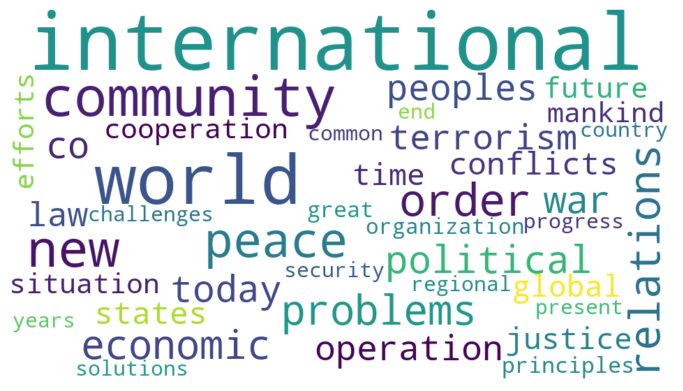

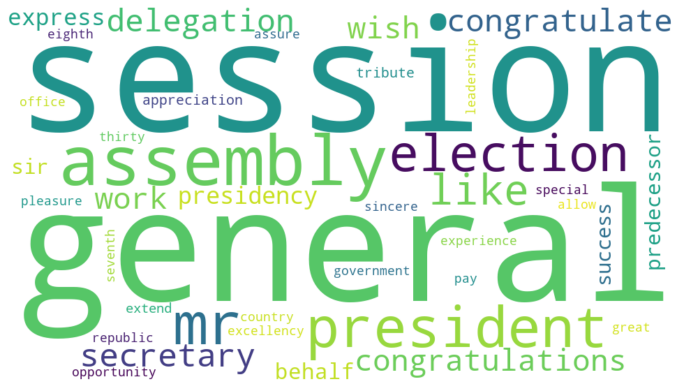

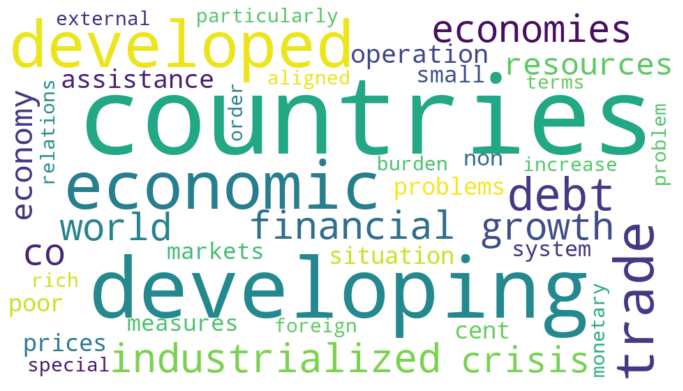

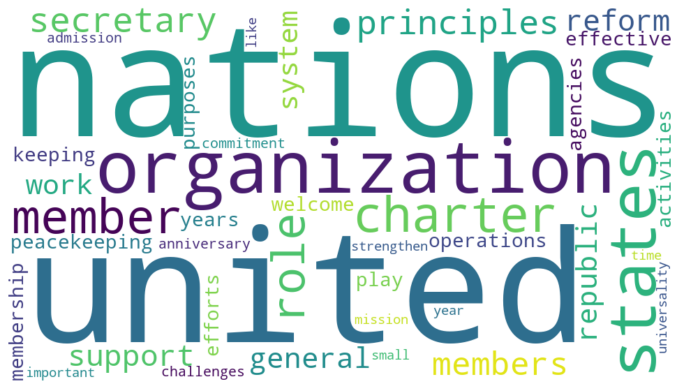

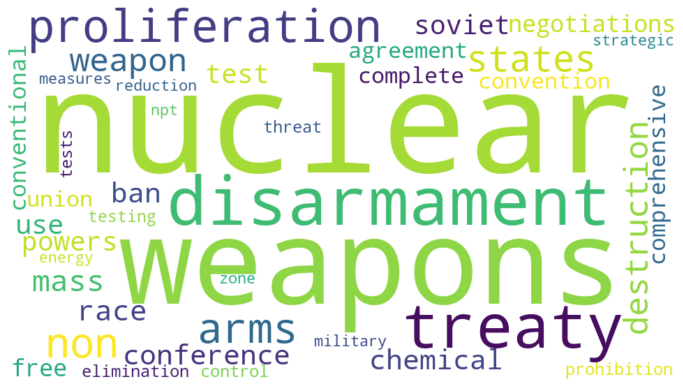

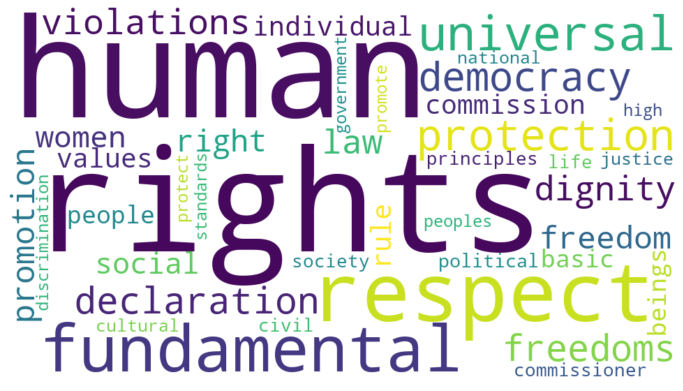

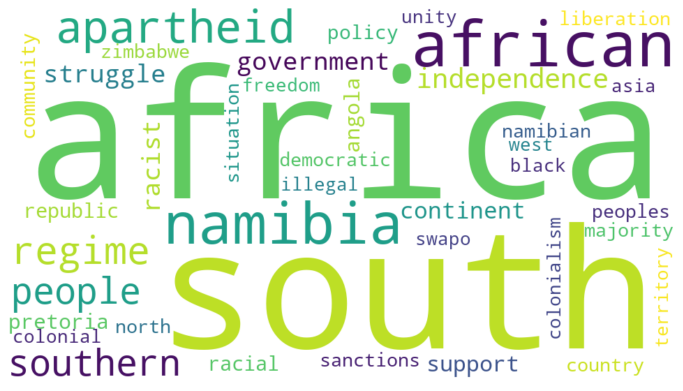

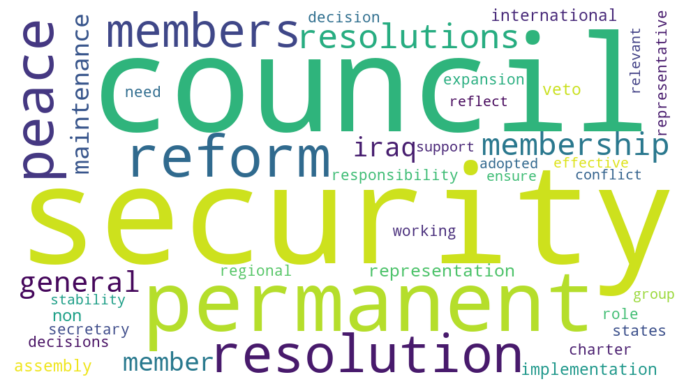

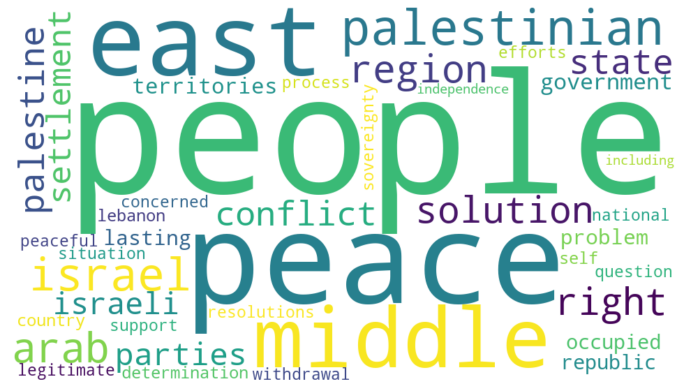

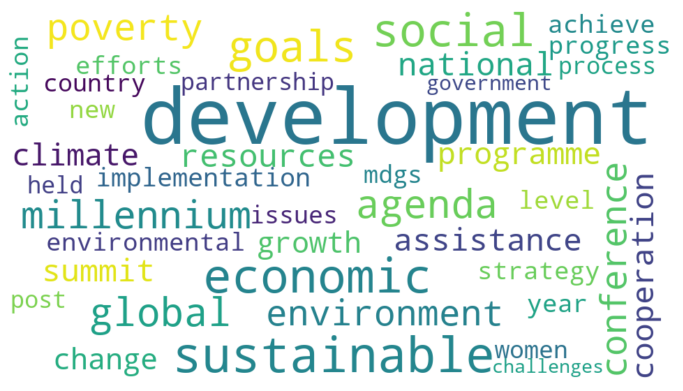

In [29]:
wordcloud_topics(nmf_para_model, tfidf_para_vectorizer.get_feature_names())

/home/jbslanka/mypython/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


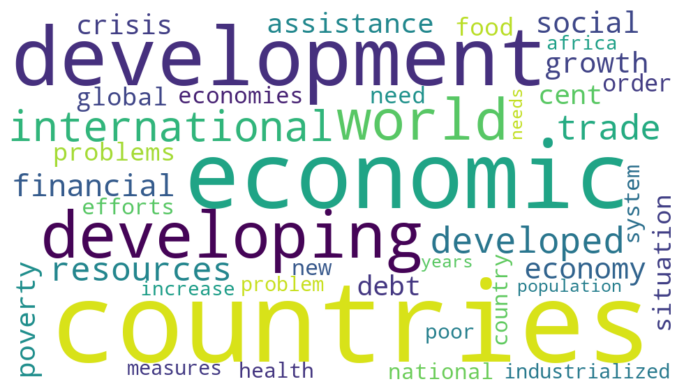

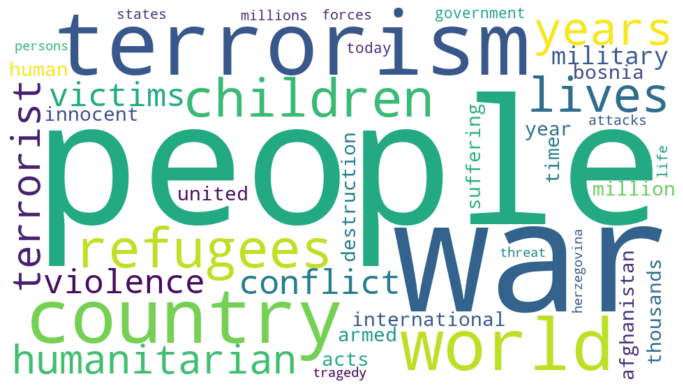

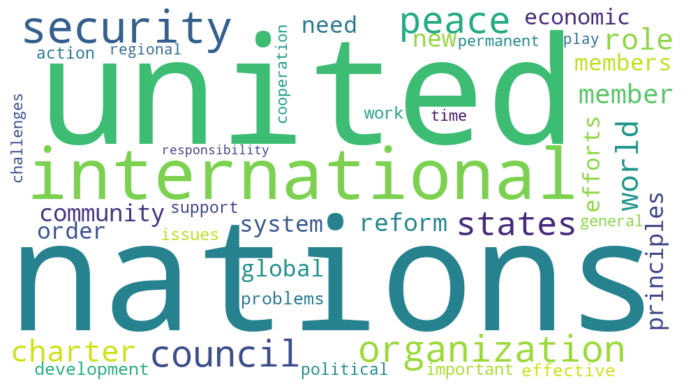

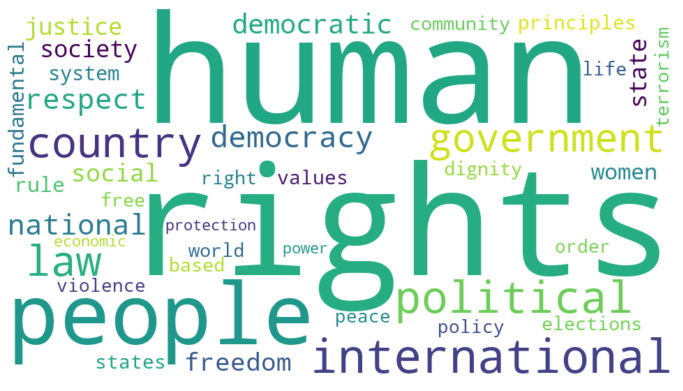

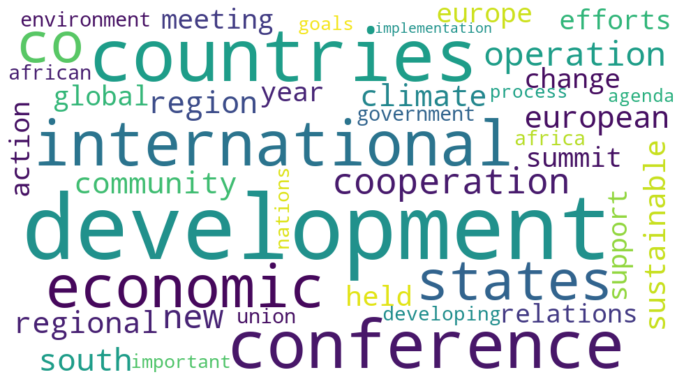

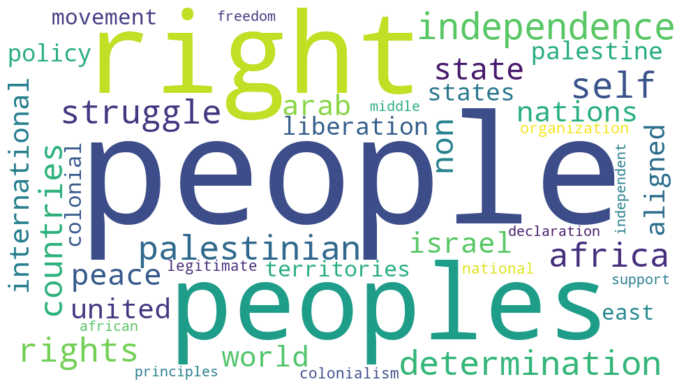

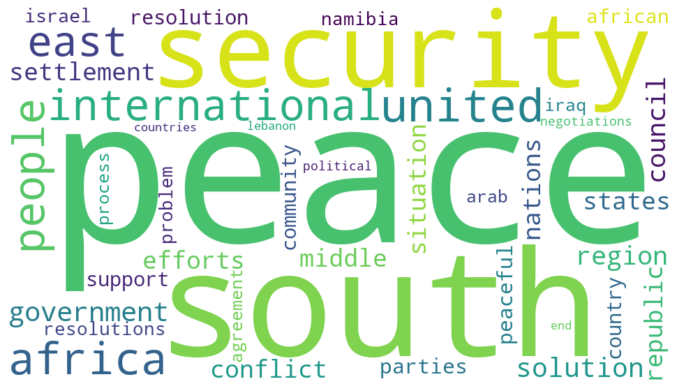

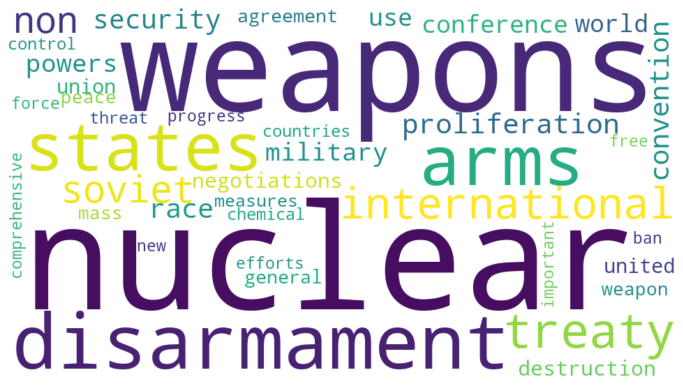

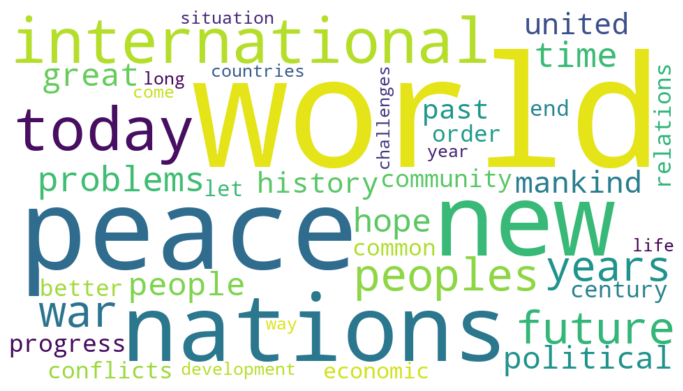

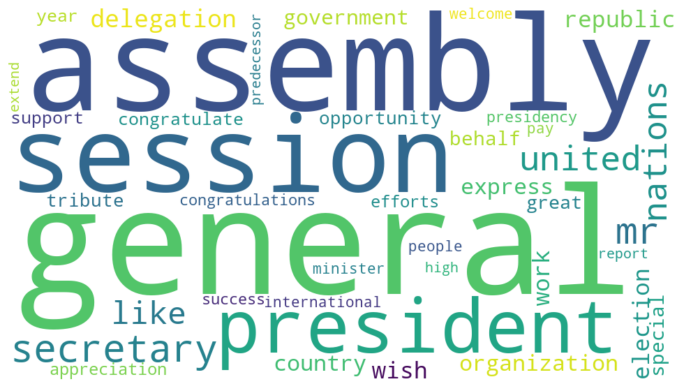

In [30]:
wordcloud_topics(lda_para_model, count_para_vectorizer.get_feature_names())